In [37]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MaDiff'
    author = 'Wang_Yue'
    
    # 策略参数
    #RSIPeriodfast = 6; RSIPeriodslow = 12
    #Cortime = 6
    stopRatio = 0.03
    lot = 10000
    #stdparam = 24
    fastmaperiod = 5
    slowmaperiod = 60
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    DelVol = {} #记录量是否增长
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'RSIPeriodfast',
                 'RSIPeriodslow',
                 'Cortime',
                 'stopRatio',
                 'stdparam'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'stdparam',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+4*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-4*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.lot)
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.lot)

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.lot)
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.lot)

    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return
        Mafast = ta.MA(am15.close,self.fastmaperiod)
        Maslow = ta.MA(am15.close,self.slowmaperiod)
        diff = Mafast - Maslow
        bol = np.abs(diff)>0.1
        angle = ta.LINEARREG_ANGLE(Maslow,5)
        i = 1
        if(bol[-i]==False):
            sum1 = 0
            sum2 = 0
            sum3 = 0
            while(bol[-i]==False and i<len(diff)):
                i = i+1
            while(bol[-i]==True and i<len(diff)):
                sum1 = sum1+diff[-i]
                i = i+1
            while(bol[-i]==False and i<len(diff)):
                i = i+1
            while(bol[-i]==True and i<len(diff)):
                sum2 = sum2+diff[-i]
                i = i+1
            while(bol[-i]==False and i<len(diff)):
                i = i+1
            while(bol[-i]==True and i<len(diff)):
                sum3 = sum3+diff[-i]
                i = i+1
            if angle[-1]>-20 and (((sum1<0) and (sum1>sum2))or(np.abs(sum2)<min(np.abs(sum1),np.abs(sum3)) and sum1<0 and sum1>sum3)):
            # 做多信号
                if  (self.posDict[symbol+'_SHORT']==0)and(self.posDict[symbol+'_LONG']==0):
                    self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
                elif self.posDict[symbol+'_SHORT'] > 0:
                    self.cancelAll() # 撤销挂单
                    self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                    self.buy(symbol, bar.close*1.01, self.lot)
        # 做空信号
            elif angle[-1]<20 and (((sum1>0) and (sum2>sum1)) or (np.abs(sum2)<min(sum1,sum3) and sum1>0 and sum1<sum3)):
                if (self.posDict[symbol+'_LONG']==0)and(self.posDict[symbol+'_SHORT']==0):
                    self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
                elif self.posDict[symbol+'_LONG'] > 0:
                    self.cancelAll() # 撤销挂单
                    self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                    self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()

    
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass


In [38]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x11f8b3730>, <__main__.MultiFrameMaStrategy object at 0x1212caf28>)
[DEBUG] 注册品种EOSUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x11f8b3f28>, <__main__.MultiFrameMaStrategy object at 0x1212caf28>)
2018-12-11 20:47:56.329458	开始回测
2018-12-11 20:47:56.329530	策略初始化
2018-12-11 20:47:56.332259	载入历史数据。数据范围:[20180623 04:00,20180701 12:00)
2018-12-11 20:47:56.884978	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-11 20:47:56.887949	载入完成，数据量：11295
2018-12-11 20:47:56.888350	策略初始化完成
2018-12-11 20:47:56.888394	策略启动完成
2018-12-11 20:47:56.888460	开始回放回测数据,回测范围:[20180701 12:00,20181121 12:00)
2018-12-11 20:47:56.910940	载入历史数据。数据范围:[20180701 12:00,20181121 12:00)
2018-12-11 20:48:06.883194	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-11 20:48:06.942513	载入完成，数据量：204833
2018-12-11 20:48:06.942902

/Users/yuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in greater


2018-07-04 03:15:00 {'EOSUSDT:binance_LONG': 10000, 'EOSUSDT:binance_SHORT': 0}
LONG stopLoss:48:09.206884	Progress: 3%    
2018-07-11 08:45:00 {'EOSUSDT:binance_LONG': 10000, 'EOSUSDT:binance_SHORT': 0}
LONG stopLoss
2018-07-15 02:15:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 10000}
SHORT stopLoss
2018-07-19 15:45:00 {'EOSUSDT:binance_LONG': 10000, 'EOSUSDT:binance_SHORT': 0}
LONG stopLoss
2018-07-24 09:45:00 {'EOSUSDT:binance_LONG': 10000, 'EOSUSDT:binance_SHORT': 0}
LONG takeProfit8:11.228492	Progress: 16%    
2018-07-27 22:15:00 {'EOSUSDT:binance_LONG': 10000, 'EOSUSDT:binance_SHORT': 0}
LONG stopLoss:48:11.860171	Progress: 20%    
2018-08-01 04:00:00 {'EOSUSDT:binance_LONG': 10000, 'EOSUSDT:binance_SHORT': 0}
LONG stopLoss
2018-08-03 13:00:00 {'EOSUSDT:binance_LONG': 10000, 'EOSUSDT:binance_SHORT': 0}
2018-08-04 11:15:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 10000}
2018-08-05 05:45:00 {'EOSUSDT:binance_LONG': 10000, 'EOSUSDT:binance_SHORT': 0}
LONG stop

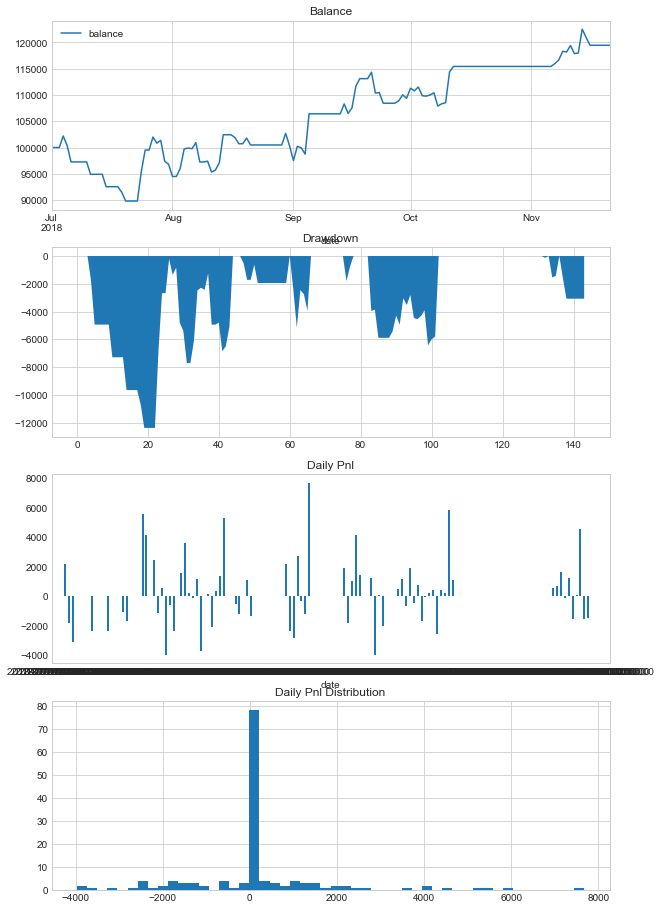

2018-12-11 20:48:27.216682	计算回测结果
2018-12-11 20:48:27.220362	------------------------------
2018-12-11 20:48:27.220515	第一笔交易：	2018-07-06 12:27:00
2018-12-11 20:48:27.220582	最后一笔交易：	2018-11-16 17:53:00
2018-12-11 20:48:27.220648	总交易次数：	25
2018-12-11 20:48:27.220721	总盈亏：	19,458.07
2018-12-11 20:48:27.220789	最大回撤: 	-10,184.34
2018-12-11 20:48:27.220844	平均每笔盈利：	778.32
2018-12-11 20:48:27.220896	平均每笔滑点：	40.0
2018-12-11 20:48:27.220959	平均每笔佣金：	62.36
2018-12-11 20:48:27.221011	胜率		40.0%
2018-12-11 20:48:27.221075	盈利交易平均值	5,218.36
2018-12-11 20:48:27.221137	亏损交易平均值	-2,181.7
2018-12-11 20:48:27.221188	盈亏比：	2.39


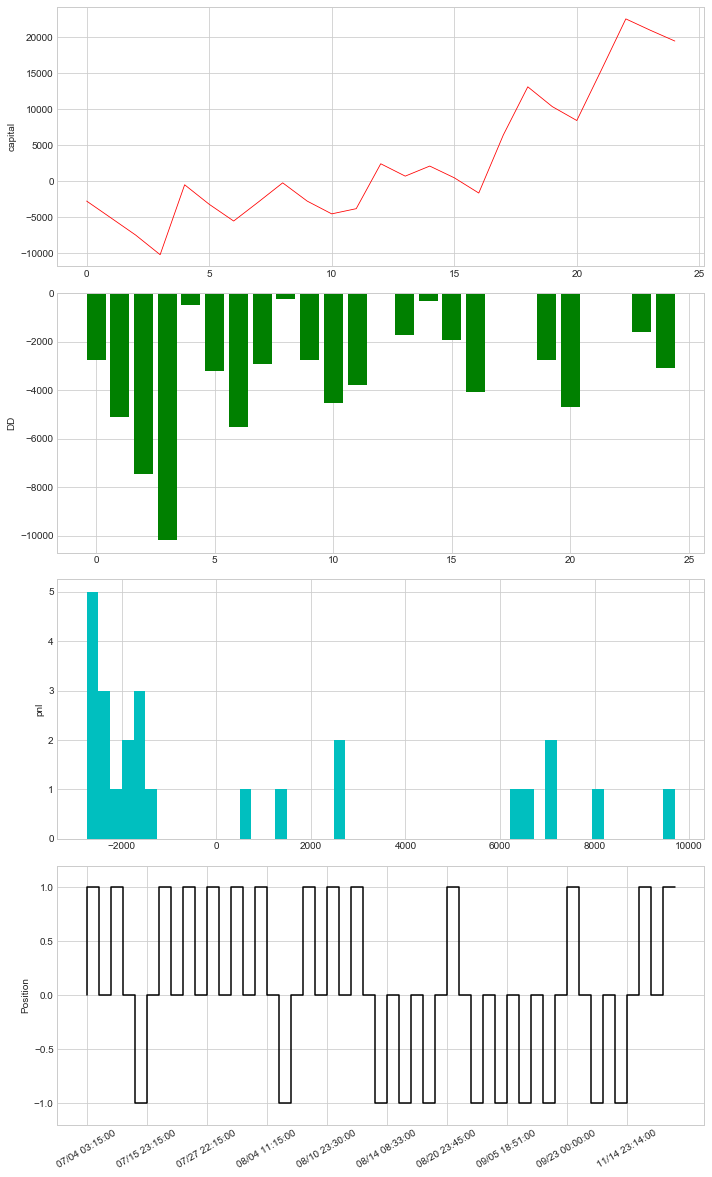

2018-12-11 20:48:28.053505	计算按日统计结果


(               netPnl  slippage  commission  turnover  tradeCount  tradingPnl  \
 date                                                                            
 2018-07-01     0.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-02     0.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-03     0.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-04  2195.4575      20.0     44.5425   89085.0           1      2260.0   
 2018-07-05 -1807.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-06 -3130.2355      20.0     43.2355   86471.0           1       912.0   
 2018-07-07     0.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-08     0.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-09     0.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-10     0.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-11 -235

In [39]:
parameterDict = {'symbolList':['EOSUSDT:binance']}
runBacktesting(MultiFrameMaStrategy, parameterDict, '20180701 12:00', '20181121 12:00', 0.002, 5/10000)